# **U Net**

## **Convolutional and Residual Neural Network in the shape of a U used to predict Radar Precipitation**

### By: Zac Singer and Thomas Upin

---

Based off of Google's Paper about predicting the weather using a U Net (no code from them available)

Google Blog: https://ai.googleblog.com/2020/01/using-machine-learning-to-nowcast.html

Google Paper: https://arxiv.org/pdf/1912.12132.pdf

---

All rights to this project are reserved to Zac Singer and Thomas Upin



### **Dataset Intializer**

Sets what type of dataset we are using

We are using a combined dataset of both mrms and hrrr weather radar images

Link to summary of mrms:
*   https://www.nssl.noaa.gov/projects/mrms/


Link to summary of hrrr:
*   https://rapidrefresh.noaa.gov/hrrr/


Our images from the dataset are located aproxiamtley above Oklahoma and around 
Nebraska

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np


# import helper
# import simulation

# Generate some random images
# input_images, target_masks = simulation.generate_random_data(256, 256, count=2)

_channels = 2
_offset = 0 # 0 = next <_channels>
            # 720 = 24 hours
# _dataset = "mrms"
# _dataset = "hrrr"
_dataset = "combined"

# _usingColab = False
_usingColab = True
"""for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())"""

'for x in [input_images, target_masks]:\n    print(x.shape)\n    print(x.min(), x.max())'

In [ ]:
if _usingColab:
    if _dataset == "mrms" and not os.path.exists("/content/output/cropped"):
        pass #TODO: get mrms dataset
    if _dataset == "hrrr" and not os.path.exists("/content/output/cropped_hrrr"):
        !gdown https://drive.google.com/uc?id=137oK3IBd7Gdr_ECpF4a7J3z7hJv1ybv1
        !unzip -q cropped_hrrr.zip
        !rm cropped_hrrr.zip
        !mkdir 'output/'
        !mv cropped_hrrr_zip/ output/cropped_hrrr
    elif _dataset == "combined" and not os.path.exists("/content/output/combined"):
        #TODO: get combined dataset
        # !gdown https://drive.google.com/uc?id=1c7x5kdLeZMcJViTVEuMiCuiBOMUN4BdH
        !gdown https://drive.google.com/uc?id=13iXddVHY-3w_ZrXbXKViCX3uE6ByKu2z
        !unzip -q combined2.zip
        !rm combined2.zip
        !mkdir 'output/'
        !mv combined/ output/combined

### **Reading Images for Training**

*Individual parameters explained within functions*

Grabbing the images from the combined dataset

Reads the images and produces the output name for interpretation

Grabs the specififed number of random images for training and validation

---


Note:

*   Images have already been processed from original grib files

---

Important Aspects:

*   Train Set: 20 (susceptible to change)
*   Validation Set: 20 (susceptible to change)

*   Batch Size: 6 (susceptible to change)

*   Number of Images: 14 million (susceptible to change)






In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import cv2
import datetime

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        """
        :param count: int, number of images
        """

        self.numImageInput = _channels*2-1
        self.count = count
        if (_dataset == "mrms"):
            self.get_images(3,3, count)
        elif (_dataset == "hrrr"):
            self.get_images(3,3, count)
        elif (_dataset == "combined"):
            self.get_images(0,0, count)
        
        print("Input: ", self.input_images.shape)
        print("Masks: ", self.target_masks.shape)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):
        """
        :param idx: int, index used looping through all the images
        """

        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

    def getNextImageName(self, path):
        """
        :param path: str, path to image for both mrms and hrrr datasets

        returns output path, example: CONUS_20180701-000000_(0, 0).png
        - year: 2018
        - month: 07, July
        - day: 01
        """

        dateStartIndex = path.find("_")+1
        year = path[dateStartIndex:dateStartIndex+4]
        month = path[dateStartIndex+4:dateStartIndex+6]
        day = path[dateStartIndex+6:dateStartIndex+8]

        timeStartIndex = path.find("-")+1
        hour=path[timeStartIndex:timeStartIndex+2]
        minute=path[timeStartIndex+2:timeStartIndex+4]

        inputImageTime = datetime.datetime(int(year), int(month), int(day), int(hour), int(minute))
        if (_dataset == "mrms"):
            timeInterval = datetime.timedelta(minutes=2)
        elif (_dataset == "hrrr" or _dataset == "combined"):
            timeInterval = datetime.timedelta(hours=1)
        outputImageTime = inputImageTime+timeInterval
        outputImageTime.strftime("%Y%m%d-%H%M00")
        outputPath = "CONUS_" + str(outputImageTime.strftime("%Y%m%d-%H%M")) +path[timeStartIndex+4:]
        return(outputPath)

    def checkImages(self, path, images, imageIndex):
        """
        :param path: str, path to image for both mrms and hrrr datasets
        :param images: list, our images
        :param imageIndex: int, index for images
        """

        if not (os.path.exists(os.path.join(path, self.getNextImageName(images[imageIndex])))):
            return False
        else:
            return True

    def get_images(self, X,Y, count):
        """
        :param X: int, x value used in end of CONUS image outputname
        :param Y: int, y value used in end of CONUS image outputname
        :param count: int, number of images
        """

        count+=self.numImageInput
        
        if (_dataset == "mrms"):
            if _usingColab:
                pass
            else:
                path = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/cropped/" + "("+str(X)+", " + str(Y) +")/"
            files= os.listdir(path)
            images = []
            for file in files:
                if file.endswith("("+str(X)+", "+str(Y)+").png"):
                    images.append(file)
            images.sort()
            rand_int = np.random.choice(len(images)-self.numImageInput-_offset, size=count-self.numImageInput, replace=False)

        elif (_dataset == "hrrr"):
            if _usingColab:
                inputPath = "/content/output/cropped_hrrr/f01" + "/("+str(X)+", " + str(Y) +")/"
                maskPath = "/content/output/cropped_hrrr/f00" + "/("+str(X)+", " + str(Y) +")/"
            else: 
                inputPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/cropped_hrrr/f01" + "/("+str(X)+", " + str(Y) +")/"
                maskPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/cropped_hrrr/f00" + "/("+str(X)+", " + str(Y) +")/"
      
            input_files=os.listdir(inputPath)
            mask_files=(os.listdir(maskPath))
            imagesInput=[]
            imagesMask=[]
            for file in input_files:
                if file.endswith(".png"):
                    imagesInput.append(file)
            for file in mask_files:
                if file.endswith(".png"):
                    imagesMask.append(file)
            imagesInput.sort()
            imagesMask.sort()
            rand_int = np.random.choice(min(len(imagesInput), len(imagesMask))-_channels-_offset, size=count-self.numImageInput, replace=False)

        elif (_dataset == "combined"):
            if _usingColab:
                inputPath = "/content/output/combined/hrrr/"
                maskPath = "/content/output/combined/mrms/"
                pressureVelocityPath = "/content/output/combined/hrrr_pressure_velocity/"
                pressurePath = "/content/output/combined/hrrr_pressure/"
                temperaturePath = "/content/output/combined/hrrr_temperature/"
            else: 
                inputPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/combined/hrrr/"
                maskPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/combined/mrms/"
                pressureVelocityPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/combined/hrrr_pressure_velocity/"
                pressurePath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/combined/hrrr_pressure/"
                temperaturePath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/combined/hrrr_temperature/"
      
            input_files=os.listdir(inputPath)
            input_pressure_velocity_files = os.listdir(pressureVelocityPath)
            input_pressure_files = os.listdir(pressurePath)
            input_temperature_files = os.listdir(temperaturePath)
            mask_files=(os.listdir(maskPath))

            imagesInput=[]
            imagesPressureVelocity=[]
            imagesPressure=[]
            imagesTemperature=[]
            imagesMask=[]

            for file in input_files:
                if file.endswith(".png"):
                    imagesInput.append(file)
            for file in input_pressure_velocity_files:
                if file.endswith(".png"):
                    imagesPressureVelocity.append(file)
            for file in input_pressure_files:
                if file.endswith(".png"):
                    imagesPressure.append(file)
            for file in input_temperature_files:
                if file.endswith(".png"):
                    imagesTemperature.append(file)
            for file in mask_files:
                if file.endswith(".png"):
                    imagesMask.append(file)
            imagesInput.sort()
            imagesPressureVelocity.sort()
            imagesPressure.sort()
            imagesTemperature.sort()
            imagesMask.sort()
            rand_int = np.random.choice(min(len(imagesInput), len(imagesMask))-_channels-_offset, size=count-self.numImageInput, replace=False)

  
        image_output = []
        image_output_temp = []
        
        print("Reading Images...")
        imageIndex=0
        rand_int_storage = rand_int
        if (_dataset == "mrms"):
            while len(image_output) < (count-self.numImageInput)*(self.numImageInput+1):
                imagesExist = True
                for i in range(self.numImageInput+1):
                    if not (self.checkImages(path, images, rand_int[imageIndex]+i)):
                        imagesExist = False
                if imagesExist:
                    for i in range(_channels):
                        input_path = os.path.join(path, images[rand_int[imageIndex]+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output.append(np.array(an_image))
                    for i in range(_channels):
                        input_path = os.path.join(path, images[rand_int[imageIndex]+i+_channels+_offset])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output.append(np.array(an_image))
                imageIndex+=1
                if imageIndex == len(rand_int):
                    print("imageIndex out of index range. Resetting rand_int and imageIndex", imageIndex)
                    rand_int = np.random.choice(len(images)-self.numImageInput, size=count-self.numImageInput, replace=False)
                    rand_int = np.setdiff1d(rand_int, rand_int_storage)
                    rand_int_storage = np.append(rand_int_storage, rand_int)
                    imageIndex=0

        elif (_dataset=="hrrr"):
            while len(image_output) < (count-self.numImageInput)*(self.numImageInput+1):
                imagesExist = True
                for i in range(_channels):
                    if not (self.checkImages(inputPath, imagesInput, rand_int[imageIndex]+i)):
                        imagesExist = False
                
                indexOfEquivalentImageInMasks=np.argwhere(np.array(imagesMask) == imagesInput[rand_int[imageIndex]])
                if (not len(indexOfEquivalentImageInMasks)):
                    imagesExist = False
                else:
                    indexOfEquivalentImageInMasks=int(indexOfEquivalentImageInMasks)+_offset+1 # add 1 because hrrr is 1 hour ahead of the mrms nowcast
                if imagesExist:
                    for i in range(_channels):
                        if not (self.checkImages(maskPath, imagesMask, indexOfEquivalentImageInMasks+i)):
                            imagesExist = False
                if imagesExist:
                    for i in range(_channels):
                        input_path = os.path.join(inputPath, imagesInput[rand_int[imageIndex]+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                    for i in range(_channels):
                        input_path = os.path.join(maskPath, imagesMask[indexOfEquivalentImageInMasks+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                    if np.max(np.array(image_output_temp)) > 0:
                        image_output.extend(np.array(image_output_temp))
                    image_output_temp = []
                imageIndex+=1
                if imageIndex == len(rand_int):
                    print("imageIndex out of index range. Resetting rand_int and imageIndex", imageIndex)
                    rand_int = np.random.choice(min(len(imagesInput), len(imagesMask))-_channels-_offset, size=count-self.numImageInput, replace=False)
                    rand_int = np.setdiff1d(rand_int, rand_int_storage)
                    rand_int_storage = np.append(rand_int_storage, rand_int)
                    imageIndex=0
        elif (_dataset=="combined"):
            while len(image_output) < (count-self.numImageInput)*(_channels*5):
                imagesExist = True
                for i in range(_channels):
                    if not (self.checkImages(inputPath, imagesInput, rand_int[imageIndex]+i)):
                        imagesExist = False
                
                indexOfEquivalentImageInMasks=np.argwhere(np.array(imagesMask) == imagesInput[rand_int[imageIndex]])
                indexOfEquivalentImageInPressureVelocity=np.argwhere(np.array(imagesPressureVelocity) == imagesInput[rand_int[imageIndex]])
                indexOfEquivalentImageInPressure=np.argwhere(np.array(imagesPressure) == imagesInput[rand_int[imageIndex]])
                indexOfEquivalentImageInTemperature=np.argwhere(np.array(imagesTemperature) == imagesInput[rand_int[imageIndex]])
                if (not len(indexOfEquivalentImageInMasks) or not len(indexOfEquivalentImageInPressureVelocity) or not len(indexOfEquivalentImageInPressure) or not len(indexOfEquivalentImageInTemperature)):
                    imagesExist = False
                else:
                    indexOfEquivalentImageInMasks=int(indexOfEquivalentImageInMasks)+_offset+1 # add 1 because hrrr is 1 hour ahead of the mrms nowcast
                    indexOfEquivalentImageInPressureVelocity=int(indexOfEquivalentImageInPressureVelocity)
                    indexOfEquivalentImageInPressure=int(indexOfEquivalentImageInPressure)
                    indexOfEquivalentImageInTemperature=int(indexOfEquivalentImageInTemperature)
                if imagesExist:
                    for i in range(_channels):
                        if not (self.checkImages(maskPath, imagesMask, indexOfEquivalentImageInMasks+i)):
                            imagesExist = False
                if imagesExist:
                    for i in range(_channels):
                        input_path = os.path.join(inputPath, imagesInput[rand_int[imageIndex]+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                        input_path = os.path.join(pressureVelocityPath, imagesPressureVelocity[indexOfEquivalentImageInPressureVelocity+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                        input_path = os.path.join(pressurePath, imagesPressure[indexOfEquivalentImageInPressure+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                        input_path = os.path.join(temperaturePath, imagesTemperature[indexOfEquivalentImageInTemperature+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                    for i in range(_channels):
                        input_path = os.path.join(maskPath, imagesMask[indexOfEquivalentImageInMasks+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output_temp.append(np.array(an_image))
                    if np.max(np.array(image_output_temp[0])) > 0 and np.max(np.array(image_output_temp[-1])) > 0:
                        image_output.extend(np.array(image_output_temp))
                    image_output_temp = []
                imageIndex+=1
                if imageIndex == len(rand_int):
                    print("imageIndex out of index range. Resetting rand_int and imageIndex", imageIndex)
                    rand_int = np.random.choice(len(imagesPressureVelocity)-_channels-_offset, size=count-self.numImageInput, replace=False)
                    rand_int = np.setdiff1d(rand_int, rand_int_storage)
                    rand_int_storage = np.append(rand_int_storage, rand_int)
                    imageIndex=0
                
            
        output_mask = []
        output = []
        image_temp = []

        print("Appending Images...")
        for i in range(count-self.numImageInput):
            mask_temp = []
            for j in range(_channels):
                if not (_dataset == "combined"):
                    mask_temp.append((np.rint(image_output[(self.numImageInput+1)*i+(self.numImageInput-(_channels-j-1))]/255*3)/3).astype("float16"))
                else:
                    mask_temp.append((np.rint(image_output[(_channels*5)*i+(_channels*5-(_channels-j))]/255*3)/3).astype("float16"))

           
            if not (_dataset == "combined"):
                image_temp = np.dstack((image_output[(self.numImageInput+1)*i], image_output[(self.numImageInput+1)*i+1]))
                if (_channels == 1):
                    image_temp = np.dsplit(image_temp, 2)[0]
                for j in range(_channels-image_temp.shape[2]):
                    image_temp = np.dstack((image_temp, image_output[(self.numImageInput+1)*i+j+2]))
            else:
                image_temp = np.dstack((image_output[(_channels*5)*i], image_output[(_channels*5)*i+1]))
                if (_channels == 1):
                    image_temp = np.dsplit(image_temp, 2)[0]
                for j in range(_channels*4-image_temp.shape[2]):
                    image_temp = np.dstack((image_temp, image_output[(_channels*5)*i+j+2]))

            output.append(image_temp)
            output_mask.append(mask_temp)
        self.input_images = np.array(output)
        self.target_masks = np.array(output_mask)

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(20, transform=trans)
val_set = SimDataset(20, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 6

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes
inputs, masks = next(iter(dataloaders['train']))

Reading Images...
imageIndex out of index range. Resetting rand_int and imageIndex 20
imageIndex out of index range. Resetting rand_int and imageIndex 20
imageIndex out of index range. Resetting rand_int and imageIndex 12
Appending Images...
Input:  (20, 256, 256, 8)
Masks:  (20, 2, 256, 256)
Reading Images...
imageIndex out of index range. Resetting rand_int and imageIndex 20
imageIndex out of index range. Resetting rand_int and imageIndex 20
Appending Images...
Input:  (20, 256, 256, 8)
Masks:  (20, 2, 256, 256)


### **Models of Pytorch Neural Net**

Displays models of our residual neural net

In [ ]:
from torchvision import models

base_model = models.resnet18(pretrained=False)
    
list(base_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
# check keras-like model summary using torchsummary
import torch
from torchsummary import summary


"""device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

#summary(base_model, input_size=(3, 224, 224))
summary(base_model, input_size=(inputs[0].shape))"""

"device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nbase_model = base_model.to(device)\n\n#summary(base_model, input_size=(3, 224, 224))\nsummary(base_model, input_size=(inputs[0].shape))"

### **Residual U Net**

Shows our layers of our residual and convolutional U Net

Both down layers and up layers

Layers based off of google paper:

*   Blog: https://ai.googleblog.com/2020/01/using-machine-learning-to-nowcast.html

*   Paper: https://arxiv.org/pdf/1912.12132.pdf

*   Note: no code provided within paper

Specific layers are exhibted within the code

Model residual UNet that we found as a template


In [ ]:
#### import torch
import torch.nn as nn

# import resnet18 #added


def createUpLayer(in_channels, out_channels, kernel, padding):
    """
    :param in_channels: list, in channels (got from template)
    :param out_channels: list, out channels (got from template)
    :param kernel: kernel (got from template)
    :param padding: padding (got from template)
    """

    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel, padding=padding)
    )

def createDownLayer(size): #added
    """
    :param size: int, size used for convolutional layers 
    """

    return(nn.Sequential(
        nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.LeakyReLU(),
        # nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.LeakyReLU(),
        nn.Conv2d(size, size*2, 3, stride = 1, padding=1)
        # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) #not in Google's model
    ))
        
def createBasicLayer(inputSize, size): #added
    """
    :param inputSize: int, inputSize used for convolutional layers
    :param size: int, size used for convolutional layers 
    """

    return(nn.Sequential(
        nn.Conv2d(inputSize, size, 3, stride = 1, padding=1),
        nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.LeakyReLU(),
        nn.Conv2d(size, size, 3, stride = 1, padding=1)
    ))


class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        """
        :param n_class: int, n_class (got from template)

        Residual neural network in the shape of a U Net 
        Up layers and downlayers displayed
        """
        
        super().__init__()      
   
        if (_dataset == "combined"):
            self.layer0 = createBasicLayer(_channels*4, 64)
        else:
            self.layer0 = createBasicLayer(_channels, 64)
        self.layer1 = createDownLayer(64)  # size=(N, 128, x.H/8, x.W/8) # changed
        self.layer2 = createDownLayer(128)  # size=(N, 256, x.H/16, x.W/16)  # changed      
        self.layer3 = createDownLayer(256)  # size=(N, 512, x.H/32, x.W/32)  # changed
        
        self.layer4 = createDownLayer(512) # added
        self.layer5 = createDownLayer(1024) # added
        self.layer6 = createDownLayer(2048) # added
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        
        self.conv_up5 = createUpLayer(4096 + 2048, 2048, 3, 1) # added
        self.conv_up4 = createUpLayer(2048 + 1024, 1024, 3, 1) # added
        
        self.conv_up3 = createUpLayer(1024 + 512, 512, 3, 1)
        self.conv_up2 = createUpLayer(512 + 256, 256, 3, 1)
        self.conv_up1 = createUpLayer(256 + 128, 128, 3, 1)
        self.conv_up0 = createUpLayer(128, 64, 3, 1)
        
        self.conv_original_size = createBasicLayer(192, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        """
        :param input: input for forward propagation

        Forward function pushes the input data in the forward direction as each
        neuron is processed and the model learns subsequently
        """

        layer0 = self.layer0(input)    
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer5 = self.layer5(layer4) #added        
        layer6 = self.layer6(layer5) #added        

        x = layer6 # added      
        
        x = self.upsample(x)
        x = torch.cat([x, layer5], dim=1)
        x = self.conv_up5(x) # added
        
        # x = self.upsample(x)
        x = torch.cat([x, layer4], dim=1)
        x = self.conv_up4(x) # added

        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = torch.cat([x, layer0], dim=1)
        
        x = self.conv_original_size(x)        
        
        out = self.conv_last(x)

        return out

### **Summary of Model and Layers**

Visualising the model and the layers using torchsummary


In [ ]:
# check keras-like model summary using torchsummary
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(_channels)

model = model.to(device)

summary(model, input_size=(inputs[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           4,672
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
       BatchNorm2d-8         [-1, 64, 128, 128]             128
         LeakyReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        LeakyReLU-12        [-1, 128, 128, 128]               0
        MaxPool2d-13          [-1, 128, 64, 64]               0
      BatchNorm2d-14          [-1, 128,

### **Training the Model**

Trains the model and visualises the loss value of the subsequent model

We use binary cross entropy with logits for our loss function

Trains the model based on previous loss values and learns from them in order to gain better prediction accuracy


In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import torch

def dice_loss(pred, target, smooth = 1.):
    """
    :param pred: tensor of predicted value
    :param target: tensor of actual value
    :param smooth: used to detect trends in noisy data to have our prediction 
                   much more generalized (this is better for weather)

    Predicted value is compared to actual value to see how off it is and model
    adjusts correspondingly 
    """

    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    """
    :param pred: tensor of predicted value
    :param target: tensor of actual value
    :param metrics: used to monitor and measure performance of the model
    :param bce_weight: used in the loss function for predictions

    calculates loss used for prediction
    """
 
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):
    """
    :param metrics: used to monitor and measure performance of the model
    :param epoch_samples: used for in comparison with metrics
    :param phase: just used for formatting in printing metrics

    printing how well the model is doing, and its metrics
    """

    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    """
    :param model: the neural net, learns over time
    :param optimizer: we use adam for our optimizer
    :param scheduler: used to set the diference between what is training mode
                      and what is validation mode 

    trains the model
    """

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Fri May 15 23:10:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    41W / 250W |   4117MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### **Visualising the Epochs and Model**

Visualises the epochs and the training of the model over time

---

Important Aspects:


*   Loss Function: Binary Cross Entropy with Logits
*   Optimizer: Adam

*   Learning Rate: 1e-3 (susceptible to change)
*   Step size: 10 (susceptible to change)

*   Gamma: 0.1 (susceptible to change)
*   Number of epochs: 20 (susceptible to change)











In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#num_class = 6
num_class = _channels

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in list(model.children()):
    for param in l.parameters():
        param.requires_grad = True

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

cuda
Epoch 0/19
----------
LR 0.001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train: bce: 0.507727, dice: 0.991126, loss: 0.749427
val: bce: 1.015552, dice: 0.911063, loss: 0.963307
saving best model
0m 4s
Epoch 1/19
----------
LR 0.001
train: bce: 0.083218, dice: 0.985812, loss: 0.534515
val: bce: 0.724527, dice: 0.979044, loss: 0.851785
saving best model
0m 4s
Epoch 2/19
----------
LR 0.001
train: bce: 0.034019, dice: 0.957385, loss: 0.495702
val: bce: 0.049286, dice: 0.987543, loss: 0.518414
saving best model
0m 4s
Epoch 3/19
----------
LR 0.001
train: bce: 0.032029, dice: 0.967047, loss: 0.499538
val: bce: 0.042788, dice: 0.993892, loss: 0.518340
saving best model
0m 4s
Epoch 4/19
----------
LR 0.001
train: bce: 0.031758, dice: 0.960009, loss: 0.495884
val: bce: 0.072943, dice: 0.981724, loss: 0.527334
0m 4s
Epoch 5/19
----------
LR 0.001
train: bce: 0.039548, dice: 0.948751, loss: 0.494149
val: bce: 0.053783, dice: 0.980302, loss: 0.517042
saving best model
0m 4s
Epoch 6/19
----------
LR 0.001
train: bce: 0.035431, dice: 0.941836, loss: 0.488633
val: bce: 0

### **Prediction**

Uses the previously trained model to predict on images 2 minutes apart

---

1st Image:
Input image

2nd Image:
Masked image

3rd Image:
Predicted image
- less specific on purpose

4th Image:
Actual Image
- 2 minutes apart from time of input image

---

INPUT SOME IMAGES HERE AS AN EXAMPLE (DO LATER)

Reading Images...
imageIndex out of index range. Resetting rand_int and imageIndex 1
imageIndex out of index range. Resetting rand_int and imageIndex 1
imageIndex out of index range. Resetting rand_int and imageIndex 1
Appending Images...
Input:  (1, 256, 256, 8)
Masks:  (1, 2, 256, 256)
(1, 2, 256, 256)


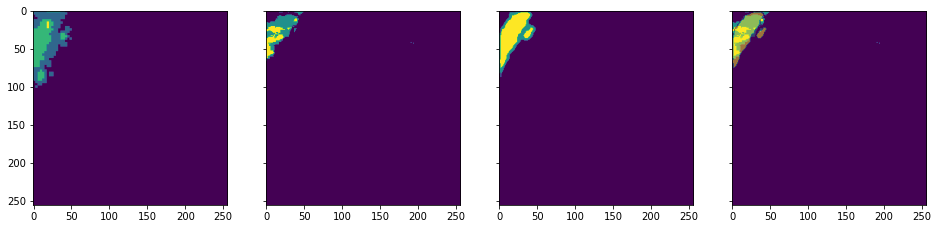

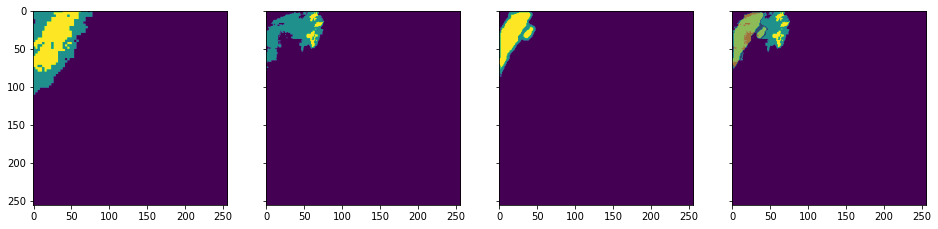

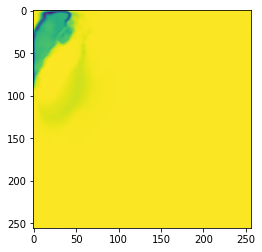

156694.7844384033


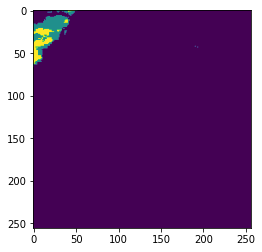

248285


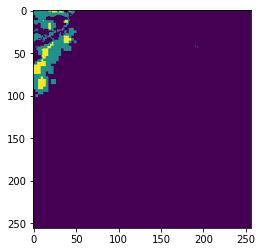

253080.12869501373


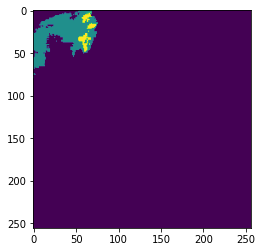

518925


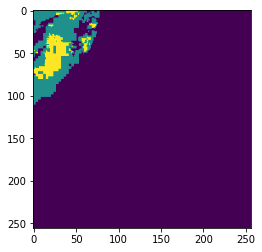

409774.913133417
767210
(1, 8, 256, 256)
(1, 2, 256, 256)
(1, 2, 256, 256)


In [ ]:
#### prediction

import math
model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(1, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

input_images_rgb = np.array(inputs.cpu())
input_images_rgb = (np.rint(input_images_rgb*3)*255/3).astype('int')

indexMultiplier = 1
if (_dataset == "combined"):
    indexMultiplier = 4

masks = (np.array(labels.cpu())*255).astype('int')

prediction = (np.rint(np.array((pred*3)))*255/3).astype('int')
prediction_masked = np.ma.masked_where(prediction == 0, prediction)
print(np.array(labels.cpu()).shape)
for image in range(pred.shape[0]):
    for channel in range(pred.shape[1]):
        f, plot = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(16, 64))
        plot[0].imshow(input_images_rgb[image][channel*indexMultiplier])
        plot[1].imshow(masks[image][channel])
        plot[2].imshow(prediction[image][channel])
        plot[3].imshow(masks[image][channel])
        plot[3].imshow(prediction_masked[image][channel], alpha=.5)
        plt.show()

plt.imshow(pred[0][0]-pred[0][-1])
plt.show()
plt.imshow(np.absolute(masks[0][0]-pred[0][0]))
print(np.sum(np.absolute(masks[0][0]-pred[0][0])))
plt.show()
plt.imshow(np.absolute(masks[0][0]-input_images_rgb[0][0]))
print(np.sum(np.absolute(masks[0][0]-input_images_rgb[0][0])))
plt.show()
if _channels > 1:
    plt.imshow(np.absolute(masks[0][1]-pred[0][1]))
    print(np.sum(np.absolute(masks[0][1]-pred[0][1])))
    plt.show()
    plt.imshow(np.absolute(masks[0][1]-input_images_rgb[0][1*indexMultiplier]))
    print(np.sum(np.absolute(masks[0][1]-input_images_rgb[0][1*indexMultiplier])))
    plt.show()

print(np.sum(np.absolute(masks-pred)))
print(np.sum(np.absolute(masks-input_images_rgb[:,::indexMultiplier])))
print(input_images_rgb.shape)
print(masks.shape)
print(pred.shape)

### **Saving the Model**

Using PyTorch to save the model, so we can load it elsewhere

In [ ]:
# torch.save(model, "/content/combined_1000:1000_batchsize-6_2_channels")

### **Acknowledgements**

*Alan Steremberg, Tony Pound, Alex Wright, Mike Bertrand, Branson Machine Learning Class*